<a href="https://colab.research.google.com/github/xy2119/SO3_Equivariant_ProteinMPNN/blob/main/notebooks/PDB_Spherical_Harmonics_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Clone github repo
import json, time, os, sys, glob

if not os.path.isdir("ProteinMPNN"):
  os.system("git clone -q https://github.com/dauparas/ProteinMPNN.git")
sys.path.append('/content/ProteinMPNN')

In [2]:
import matplotlib.pyplot as plt
import shutil
import warnings
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path

In [3]:
import re
from google.colab import files
import numpy as np

#########################
def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  else:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"

#@markdown ### Input Options
pdb='1O91' #@param {type:"string"}
pdb_path = get_pdb(pdb)
#@markdown - pdb code (leave blank to get an upload prompt)
pdb_path

'1O91.pdb'

In [4]:
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN

###############################################################
chain_list=[]
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)


In [5]:
for i in pdb_dict_list:
  print('pdb_dict_list:\n',i.keys())
  print('\n')
  print('seq:\n',i['seq'])
  print('seq_chain_A:\n',i['seq_chain_A'])
  print('coords_chain_A:\n',i['coords_chain_A'].keys())
  print('\n')
  print('No. of Coords N_chain_A:',len(i['coords_chain_A']['N_chain_A']),'\n',i['coords_chain_A']['N_chain_A'][:3])
  print('\n')
  print('No. of Coords CA_chain_A:',len(i['coords_chain_A']['CA_chain_A']),'\n',i['coords_chain_A']['CA_chain_A'][:3])
  print('\n')
  print('No. of Coords C_chain_A:',len(i['coords_chain_A']['C_chain_A']),'\n',i['coords_chain_A']['C_chain_A'][:3])
  print('\n')
  print('No. of Coords O_chain_A:',len(i['coords_chain_A']['O_chain_A']),'\n',i['coords_chain_A']['O_chain_A'][:3])
  print('\n')
  print(i['num_of_chains'])
  print('coords_chain_B:\n',i['coords_chain_B'].keys())
  print('\n')
  print('No. of Coords N_chain_B:',len(i['coords_chain_B']['N_chain_B']),'\n',i['coords_chain_B']['N_chain_B'][:3])
  print('\n')
  print('No. of Coords CA_chain_B:',len(i['coords_chain_B']['CA_chain_B']),'\n',i['coords_chain_B']['CA_chain_B'][:3])
  print('\n')
  print('No. of Coords C_chain_B:',len(i['coords_chain_B']['C_chain_B']),'\n',i['coords_chain_B']['C_chain_B'][:3])
  print('\n')
  print('No. of Coords O_chain_B:',len(i['coords_chain_B']['O_chain_B']),'\n',i['coords_chain_B']['O_chain_B'][:3])
  print('\n')

pdb_dict_list:
 dict_keys(['seq_chain_A', 'coords_chain_A', 'seq_chain_B', 'coords_chain_B', 'seq_chain_C', 'coords_chain_C', 'name', 'num_of_chains', 'seq'])


seq:
 EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPMEMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPMEMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPM
seq_chain_A:
 EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPM
coords_chain_A:
 dict_keys(['N_chain_A', 'CA_chain_A', 'C_chain_A', 'O_chain_A'])


No. of Coords N_chain_A: 131 
 [[-4.825, -16.271, 35.102], [-3.63, -12.953, 34.821], [-3.688, -10.279, 32.364]]


No. of Coords CA_chain_A: 131 
 [[-3.657, -15.384, 34.838], [-4.024, -11.614, 34.391], [-2.953,

In [6]:
N_A=np.array(pdb_dict_list[0]['coords_chain_A']['N_chain_A'])
N_A.shape

(131, 3)

In [7]:
N_A[:10]

array([[ -4.825, -16.271,  35.102],
       [ -3.63 , -12.953,  34.821],
       [ -3.688, -10.279,  32.364],
       [ -0.75 ,  -8.697,  31.569],
       [  2.27 ,  -6.944,  30.894],
       [  5.742,  -6.22 ,  29.963],
       [  7.88 ,  -5.033,  27.687],
       [ 11.026,  -4.709,  26.172],
       [ 12.991,  -2.771,  23.897],
       [ 15.797,  -3.665,  22.123]])

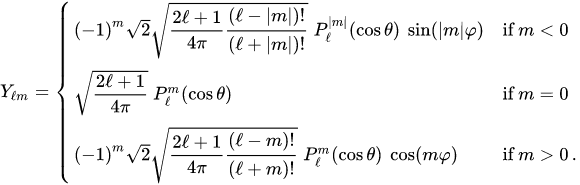

In [79]:
import math
import numpy as np
from scipy.special import sph_harm


# define the spherical harmonic Y_lm
def Y_lm(l, m, theta, phi):
    """
    Computes the spherical harmonics function Y_lm.
    
    Parameters:
    l (int): Degree of the spherical harmonics function.
    m (int): Order of the spherical harmonics function.
    theta (numpy array): Azimuthal angles in spherical coordinates.
    phi (numpy array): Polar angles in spherical coordinates.
    
    Returns:
    numpy array: Spherical harmonics function Y_lm.
    """
    # Compute the prefactor
    
    prefactor = np.sqrt((2*l+1)/(4*np.pi)) * np.sqrt(math.perm(l-m)/math.perm(l+m))
    print('prefactor',prefactor)
    # Calculate the value of the spherical harmonic
    harmonic = sph_harm(m, l, theta.T, phi.T)

    # Multiply the prefactor by the harmonic, and apply the phase shift
    if m < 0:
        result = prefactor * np.sin(-m*phi) * harmonic
    elif m == 0:
        result = prefactor * harmonic
    else:
        result = prefactor * np.cos(m*phi) * harmonic

    # Multiply the prefactor by the harmonic, and apply the phase shift
    result = prefactor * np.cos(m*phi) * harmonic
    print('l,m:',l,m)
    print('loc',l**2+l+m)
    print('coef',result.real)
    # Convert the result to a scalar value
    return result.real
 
def reconstruct_Y_lm(expand_coef, l_max, theta, phi):
    """
    Reconstructs the spherical harmonics function Y_lm from the expansion coefficients.
    
    Parameters:
    expand_coef (numpy array): Expansion coefficients of the spherical harmonics function.
    l_max (int): Maximum degree of the spherical harmonics expansion.
    theta (numpy array): Azimuthal angles in spherical coordinates.
    phi (numpy array): Polar angles in spherical coordinates.
    
    Returns:
    numpy array: Reconstructed spherical harmonics function Y_lm.
    """
    # Initialize the reconstructed Y_lm to 0
    reconstructed_Y_lm = 0
    
    # Loop over l and m
    for l in range(l_max+1):
        for m in range(-l, l+1):
            # Retrieve the expansion coefficient for the given l and m
            coef = expand_coef[:,l**2 + l + m]
            # Compute the spherical harmonic for the given l and m
            harmonic = sph_harm(m, l, theta.T, phi.T)

            # Add the product of the expansion coefficient and the spherical harmonic to the reconstructed Y_lm
            reconstructed_Y_lm += coef.reshape(-1,1) * harmonic

    return reconstructed_Y_lm

def reconstruct_from_spherical_harmonics(expand_matrix, r, theta, phi, l_max):
    """
    Reconstructs the 3D Cartesian coordinates from the expansion coefficients of the spherical harmonics representation.
    
    Parameters:
    expand_coef (numpy array): Invariant combination of expansion coefficients of the spherical harmonics.
    l_max (int): Maximum degree of the spherical harmonics expansion.
    
    Returns:
    numpy array: 3D Cartesian coordinates of protein atoms.
    """
    # Initialize the reconstructed coordinates array
    reconstructed_coordinates = np.zeros((expand_matrix.shape[0], 3))
    
    # Loop over l and m
    for l in range(l_max+1):
        for m in range(-l, l+1):
            # Retrieve the expansion coefficient for the given l and m
            coef = expand_matrix[:, l**2+l+m]
            # Compute the spherical harmonic for the given l and m
            #harmonic = sph_harm(m, l, theta.T, phi.T)

            # Convert the spherical harmonic to Cartesian coordinates
            x = r * np.sin(theta) * np.cos(phi)
            y = r * np.sin(theta) * np.sin(phi)
            z = r * np.cos(theta)
            # Add the Cartesian coordinates to the reconstructed coordinates array
            reconstructed_coordinates += coef.reshape(-1,1) * np.stack((x, y, z), axis=1)

            print('RECON coef:\n',coef.reshape(-1,1))
            #print('RECON harmonic:',harmonic)
    
    return reconstructed_coordinates


def reduce_dimensions_with_spherical_harmonics(coordinates, l_max):
    """
    Reduces the dimensions of the protein coordinates using the expansion coefficients of the spherical harmonics representation.
    
    Parameters:
    coordinates (numpy array): 3D Cartesian coordinates of protein atoms.
    l_max (int): Maximum degree of the spherical harmonics expansion.
    
    Returns:
    numpy array: Invariant combination of expansion coefficients of the spherical harmonics.
    """
    # Convert the Cartesian coordinates to spherical coordinates
    r = np.linalg.norm(coordinates, axis=1)
    theta = np.arccos(coordinates[:,2] / r)
    phi = np.arctan2(coordinates[:,1], coordinates[:,0])

    # initialize the matrix
    expand_coef=np.zeros((len(theta), l_max+1), dtype=complex)
    expand_matrix = np.zeros((len(theta), (l_max+1)**2), dtype=complex)
    print('theta,phi:',theta,phi)
    print('expand_matrix.shape:',expand_matrix.shape)
    # loop over l and m
    for l in range(l_max+1):
      for m in range(-l, l+1):
        coef=Y_lm(l, m, theta, phi)
        expand_coef[:,l] += (coef**2)
        # add the values of Y_lm to the matrix
        expand_matrix[:,l**2+l+m] = coef

    print('expand_coef:\n',expand_coef.real)
    # Compute the invariant L2 norm of the expansion coefficients
    l2_norm = np.sqrt(np.sum(expand_coef,axis=1))
    print('l2_norm:\n',l2_norm.real)
    print('expand_matrix:\n',expand_matrix.real)
    recon=reconstruct_Y_lm(expand_matrix.real, l_max,theta, phi)
    #recon=reconstruct_from_sph_harmonics(expand_matrix.real,theta,phi,l_max)
    print('recon:',recon.real)
    return expand_matrix.real,l2_norm.real

""" # Compute the spherical harmonics expansion of the function defined by the protein coordinates
    Y_lm = sph_harm(m, l, phi, theta)
    
    # Truncate the expansion at the specified degree
    Y_lm = Y_lm[:, :l_max+1, :l_max+1]
    
    # Compute the invariant combination of the expansion coefficients
    invariant = np.sum(np.abs(Y_lm)**2, axis=(1,2))
    
    return invariant
"""

' # Compute the spherical harmonics expansion of the function defined by the protein coordinates\n    Y_lm = sph_harm(m, l, phi, theta)\n    \n    # Truncate the expansion at the specified degree\n    Y_lm = Y_lm[:, :l_max+1, :l_max+1]\n    \n    # Compute the invariant combination of the expansion coefficients\n    invariant = np.sum(np.abs(Y_lm)**2, axis=(1,2))\n    \n    return invariant\n'

In [80]:
N_A[:4],N_A[:4].T,N_A[:4][:,1]

(array([[ -4.825, -16.271,  35.102],
        [ -3.63 , -12.953,  34.821],
        [ -3.688, -10.279,  32.364],
        [ -0.75 ,  -8.697,  31.569]]),
 array([[ -4.825,  -3.63 ,  -3.688,  -0.75 ],
        [-16.271, -12.953, -10.279,  -8.697],
        [ 35.102,  34.821,  32.364,  31.569]]),
 array([-16.271, -12.953, -10.279,  -8.697]))

In [84]:
m,l2=reduce_dimensions_with_spherical_harmonics(N_A[:4],l_max=4)
l2

theta,phi: [0.45034946 0.36865746 0.32543304 0.26977347] [-1.85907566 -1.84403124 -1.91528011 -1.65682014]
expand_matrix.shape: (4, 25)
prefactor 0.28209479177387814
l,m: 0 0
loc 0
coef [0.07957747 0.07957747 0.07957747 0.07957747]
prefactor 0.690988298942671
l,m: 1 -1
loc 1
coef [-0.0585836  -0.05786379 -0.07190287 -0.01969638]
prefactor 0.4886025119029199
l,m: 1 0
loc 2
coef [-0.06787234 -0.0644214  -0.08062252 -0.02051135]
prefactor 0.3454941494713355
l,m: 1 1
loc 3
coef [0.0292918  0.02893189 0.03595143 0.00984819]
prefactor 3.0901936161855166
l,m: 2 -2
loc 4
coef [-0.57126201 -0.6999766  -0.64942124 -1.00152476]
prefactor 1.5450968080927583
l,m: 2 -1
loc 5
coef [0.08327746 0.07807206 0.12141189 0.00846134]
prefactor 0.6307831305050401
l,m: 2 0
loc 6
coef [-0.15070291 -0.15548375 -0.13087593 -0.19453796]
prefactor 0.2575161346821264
l,m: 2 1
loc 7
coef [-0.01387958 -0.01301201 -0.02023531 -0.00141022]
prefactor 0.1287580673410632
l,m: 2 2
loc 8
coef [-0.02380258 -0.02916569 -0.0270

array([ 7.00179517,  7.36071118, 11.29258282, 33.28088256])

In [85]:
N_A[:4]

array([[ -4.825, -16.271,  35.102],
       [ -3.63 , -12.953,  34.821],
       [ -3.688, -10.279,  32.364],
       [ -0.75 ,  -8.697,  31.569]])

cleaned

In [86]:
import math
import numpy as np
from scipy.special import sph_harm


# define the spherical harmonic Y_lm
def Y_lm(l, m, theta, phi):
    # Compute the prefactor
    
    prefactor = np.sqrt((2*l+1)/(4*np.pi)) * np.sqrt(math.perm(l-m)/math.perm(l+m))
    # Calculate the value of the spherical harmonic
    harmonic = sph_harm(m, l, theta.T, phi.T)

    # Multiply the prefactor by the harmonic, and apply the phase shift
    if m < 0:
        result = prefactor * np.sin(-m*phi) * harmonic
    elif m == 0:
        result = prefactor * harmonic
    else:
        result = prefactor * np.cos(m*phi) * harmonic

    # Multiply the prefactor by the harmonic, and apply the phase shift
    result = prefactor * np.cos(m*phi) * harmonic
    # Convert the result to a scalar value
    return result.real

def reduce_dimensions_with_spherical_harmonics(coordinates, l_max):
    """
    Reduces the dimensions of the protein coordinates using the expansion coefficients of the spherical harmonics representation.
    
    Parameters:
    coordinates (numpy array): 3D Cartesian coordinates of protein atoms.
    l_max (int): Maximum degree of the spherical harmonics expansion.
    
    Returns:
    numpy array: Invariant combination of expansion coefficients of the spherical harmonics.
    """
    # Convert the Cartesian coordinates to spherical coordinates
    r = np.linalg.norm(coordinates, axis=1)
    theta = np.arccos(coordinates[:,2] / r)
    phi = np.arctan2(coordinates[:,1], coordinates[:,0])

    # initialize the matrix
    expand_coef=np.zeros((len(theta), l_max+1), dtype=complex)
    expand_matrix = np.zeros((len(theta), (l_max+1)**2), dtype=complex)

    # loop over l and m
    for l in range(l_max+1):
      for m in range(-l, l+1):
        coef=Y_lm(l, m, theta, phi)
        expand_coef[:,l] += (coef**2)
        # add the values of Y_lm to the matrix
        expand_matrix[:,l**2+l+m] = coef
    # Compute the invariant L2 norm of the expansion coefficients
    l2_norm = np.sqrt(np.sum(expand_coef,axis=1))
    return expand_matrix.real,l2_norm.real


In [87]:
m,l2=reduce_dimensions_with_spherical_harmonics(N_A[-2:],1)
l2

array([0.2495505 , 0.24993912])

In [88]:
m,l2=reduce_dimensions_with_spherical_harmonics(N_A[-2:],2)
l2

array([0.56120178, 0.53944369])

In [90]:
m,l2=reduce_dimensions_with_spherical_harmonics(N_A[-2:],4)
l2

array([3.12997703, 2.67459118])

In [92]:
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=100)

